In [157]:
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential

In [158]:
import seaborn as sns
from sklearn.metrics import classification_report


In [159]:
files = os.listdir('data/')
df = pd.DataFrame()

for file in range(len(files)):
    dfTemp = pd.read_json(f'data/dutch_tweets/dutch_tweets_chunk{file}.json')
    df = pd.concat([df, dfTemp])
df.dropna(subset=['longitude', 'latitude'], inplace=True)
df['longitude'] = df['longitude'].round(1)
df['latitude'] = df['latitude'].round(1)
df = df[df['subjective_pattern'] != 0]

# Use apply with a lambda function for concatenation
df['lat_long'] = df.apply(lambda row: str(row['latitude']) + ', ' + str(row['longitude']), axis=1)

In [160]:
def unix_ms_to_datetime(date):
    if(type(date) == 'timestamp'):
        return date.tz_localize(None)
    elif isinstance(date, str) and ':' in date: 
        return pd.to_datetime(date).tz_localize(None)
    else:
        return pd.to_datetime(date, unit='ms').tz_localize(None)

df['created_at'] = df['created_at'].apply(unix_ms_to_datetime)

In [161]:
df = df[df['subjective_pattern'] > 0]

def buckets(val):
    return (1 if val > 0 else -1)
    # return (1 if val > .5 else (-1 if val < -0.5 else 0))

df['target'] = df['sentiment_pattern'].apply(buckets)

In [162]:
amsterdam_lat_long = '52.4, 4.9'
rotterdam_lat_long = '51.9, 4.5'
hague_lat_long = '52.1, 4.3'

amsterdam = df[df['lat_long'] == '52.4, 4.9']
rotterdam = df[df['lat_long'] == '51.9, 4.5']
hague = df[df['lat_long'] == '52.1, 4.3']

In [163]:
amsterdam = amsterdam.groupby(pd.Grouper(key='created_at', freq='D')).mean('target')
rotterdam = rotterdam.groupby(pd.Grouper(key='created_at', freq='D')).mean('target')
hague = hague.groupby(pd.Grouper(key='created_at', freq='D')).mean('target')

In [164]:
weatherAmsterdam = pd.read_csv('./amsterdam.csv')
weatherRotterdam = pd.read_csv('./rotterdam.csv')
weatherHague = pd.read_csv('./hague.csv')

In [165]:
weatherAmsterdam['date'] = pd.to_datetime(weatherAmsterdam['date'], format='%Y-%m-%d %X')
weatherRotterdam['date'] = pd.to_datetime(weatherRotterdam['date'], format='%Y-%m-%d %X')
weatherHague['date'] = pd.to_datetime(weatherHague['date'], format='%Y-%m-%d %X')

In [166]:
weatherAmsterdamComb = weatherAmsterdam.dropna(axis=0).groupby(pd.Grouper(key='date', freq='D')).mean([*weatherAmsterdam.columns])
weatherRotterdamComb = weatherRotterdam.dropna(axis=0).groupby(pd.Grouper(key='date', freq='D')).mean([*weatherAmsterdam.columns])
weatherHagueComb = weatherHague.dropna(axis=0).groupby(pd.Grouper(key='date', freq='D')).mean([*weatherAmsterdam.columns])

In [167]:
amsterdamComb = pd.merge(amsterdam, weatherAmsterdamComb, left_index=True, right_index=True)
amsterdamComb = amsterdamComb[['target', 'surface_pressure', 'surface_solar_radiation', 'relative_humidity']]

In [168]:
rotterdamComb = pd.merge(rotterdam, weatherRotterdamComb, left_index=True, right_index=True)
rotterdamComb = rotterdamComb[['target', 'surface_pressure', 'surface_solar_radiation', 'relative_humidity']]

In [169]:
hagueComb = pd.merge(amsterdam, weatherHagueComb, left_index=True, right_index=True)
hagueComb = hagueComb[['target', 'surface_pressure', 'surface_solar_radiation', 'relative_humidity']]

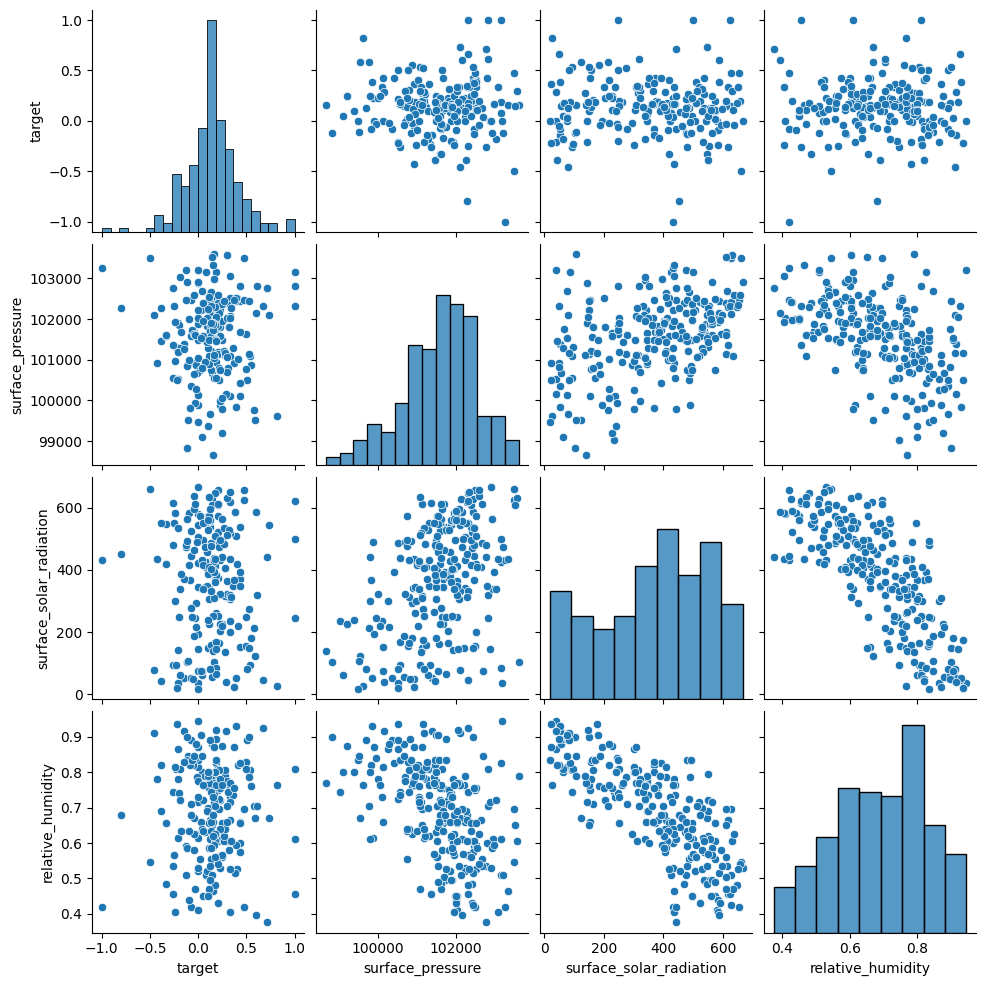

In [170]:
sns.pairplot(amsterdamComb)

In [171]:
from sklearn.preprocessing import StandardScaler

In [172]:
scalar = StandardScaler()
scaledAmsterdam = pd.DataFrame(scalar.fit_transform(amsterdamComb), columns=amsterdamComb.columns)

In [173]:
scaledRotterdam = pd.DataFrame(scalar.fit_transform(rotterdamComb), columns=rotterdamComb.columns)

In [174]:
scaledHague = pd.DataFrame(scalar.fit_transform(hagueComb), columns=hagueComb.columns)

In [175]:
scaled = pd.concat([scaledAmsterdam, scaledRotterdam, scaledHague], ignore_index=True)

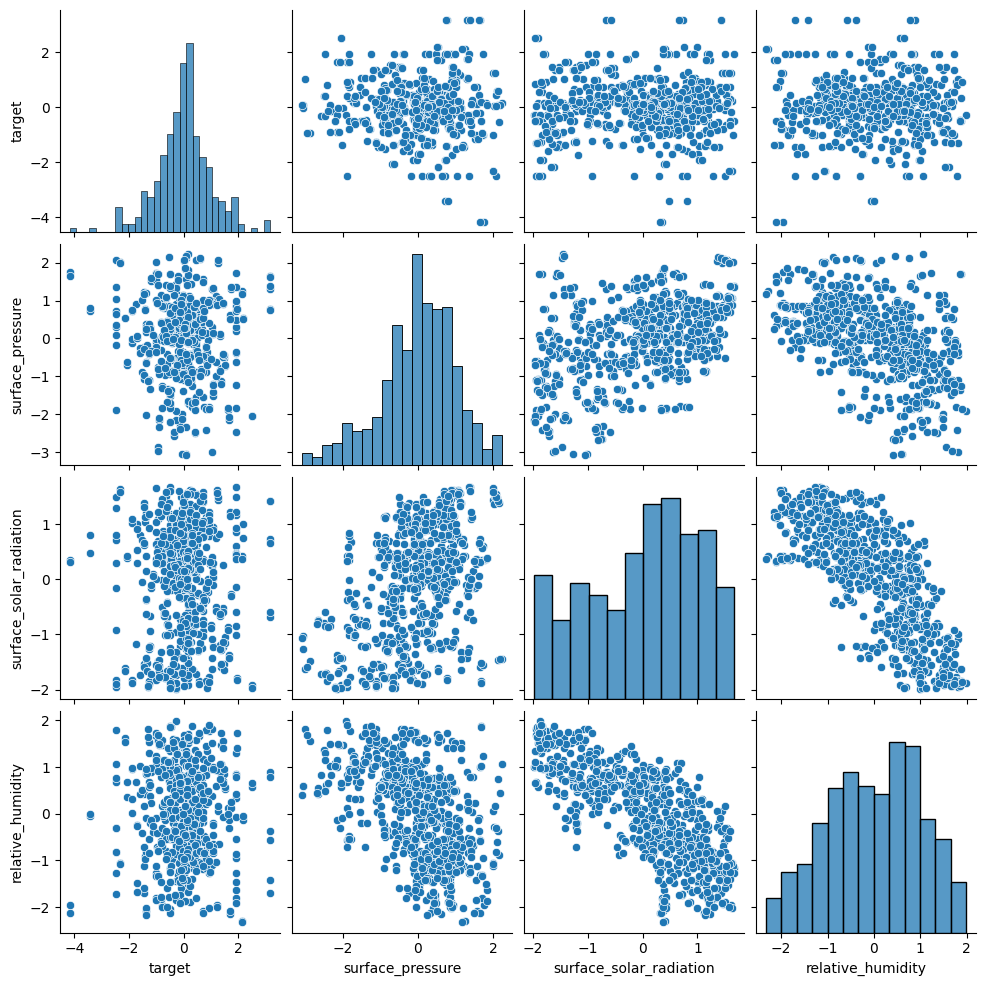

In [176]:
sns.pairplot(scaled)

In [177]:
def bucketsAgg(val):
    return 1 if val > 0 else 0

In [178]:
scaled['target'] = scaled['target'].apply(bucketsAgg)

In [179]:
scaled

,target,surface_pressure,surface_solar_radiation,relative_humidity
0,0,1.689713,-1.847259,1.882428
1,1,0.766277,-1.792404,1.735984
2,0,0.548583,-1.614097,1.626151
3,0,-0.186986,-1.769622,1.662762
4,0,-1.266225,-1.763885,1.479707
...,...,...,...,...
733,0,0.083470,0.056542,-0.255443
734,0,-0.572871,-0.217305,0.822384
735,0,-1.392885,-0.831197,1.112568
736,1,-1.670699,-0.715613,0.324926


<Axes: >

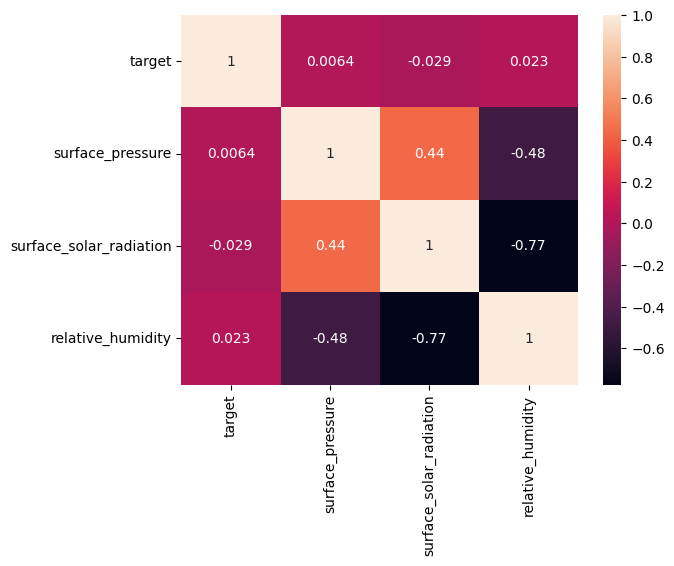

In [180]:
sns.heatmap(scaled.corr(), annot=True)

<Axes: xlabel='surface_pressure', ylabel='target'>

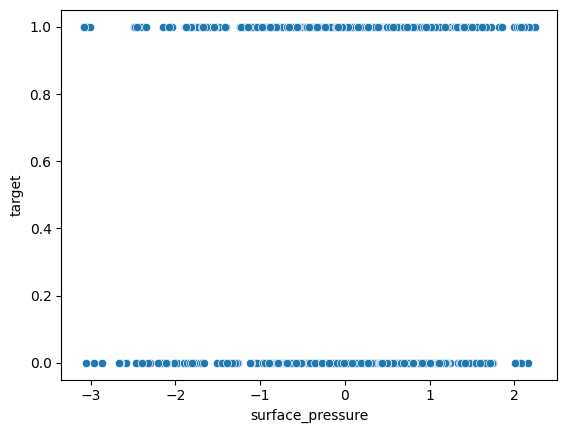

In [181]:
sns.scatterplot(scaled, x='surface_pressure',y='target')

In [182]:
from sklearn.model_selection import train_test_split

In [183]:
from sklearn.neural_network import MLPClassifier

In [184]:
amsterdamTarg = scaled['target']
amsterdamComb2 = scaled.drop('target',axis=1)

In [185]:
xtrain, xtest, ytrain, ytest = train_test_split(amsterdamComb2, amsterdamTarg, test_size=.5)

In [201]:
mlp = MLPClassifier((4,28,32,8,3),learning_rate='adaptive',verbose=True)

In [202]:
mlp.fit(xtrain, ytrain)

Iteration 1, loss = 0.72277133
Iteration 2, loss = 0.70085075
Iteration 3, loss = 0.68565459
Iteration 4, loss = 0.67905298
Iteration 5, loss = 0.67481513
Iteration 6, loss = 0.67495463
Iteration 7, loss = 0.67548487
Iteration 8, loss = 0.67431572
Iteration 9, loss = 0.67290818
Iteration 10, loss = 0.67127987
Iteration 11, loss = 0.66968795
Iteration 12, loss = 0.66796122
Iteration 13, loss = 0.66622986
Iteration 14, loss = 0.66495933
Iteration 15, loss = 0.66389560
Iteration 16, loss = 0.66329638
Iteration 17, loss = 0.66279199
Iteration 18, loss = 0.66205957
Iteration 19, loss = 0.66137522
Iteration 20, loss = 0.66093052
Iteration 21, loss = 0.66001844
Iteration 22, loss = 0.65925171
Iteration 23, loss = 0.65861955
Iteration 24, loss = 0.65815108
Iteration 25, loss = 0.65754663
Iteration 26, loss = 0.65708969
Iteration 27, loss = 0.65679869
Iteration 28, loss = 0.65625368
Iteration 29, loss = 0.65570749
Iteration 30, loss = 0.65521597
Iteration 31, loss = 0.65481369
Iteration 32, los

c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(4, 28, 32, 8, 3), learning_rate='adaptive',
              verbose=True)

In [203]:
predictions = mlp.predict(xtest)

In [204]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65       207
           1       0.51      0.36      0.42       162

    accuracy                           0.57       369
   macro avg       0.55      0.54      0.54       369
weighted avg       0.56      0.57      0.55       369



In [205]:
model = Sequential()

# model.add(layers.Input(shape=(3,)))
model.add(layers.Dense(4, activation="relu"))
model.add(layers.Dense(28, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [206]:
myIn = tf.convert_to_tensor(xtrain)
model.fit(myIn, ytrain, batch_size=64, epochs=1000)

predictions = []
for i in model.predict(xtest):
    predictions.append(0 if i < .5 else 1)


Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6067 - loss: 0.6894
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5860 - loss: 0.6846 
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5962 - loss: 0.6830 
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5583 - loss: 0.6900 
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5947 - loss: 0.6814 
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5873 - loss: 0.6805 
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6178 - loss: 0.6737 
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5791 - loss: 0.6771 
Epoch 9/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5887 - loss: 0.6764 
Epoch 10/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6005 - loss: 0.6740 
Epoch 11/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5792 - loss: 0.6780 
Epoch 12/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0

In [62]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,139 (16.17 KB)

 Trainable params: 1,379 (5.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,760 (10.79 KB)

In [207]:
print(classification_report(ytest, predictions))


              precision    recall  f1-score   support

           0       0.61      0.64      0.62       207
           1       0.51      0.48      0.49       162

    accuracy                           0.57       369
   macro avg       0.56      0.56      0.56       369
weighted avg       0.56      0.57      0.56       369



In [208]:
from sklearn.tree import DecisionTreeClassifier

In [209]:
decTree = DecisionTreeClassifier()
decTree.fit(xtrain, ytrain)

DecisionTreeClassifier()

In [210]:
predictionsDecTree = decTree.predict(xtest)
print(classification_report(ytest, predictionsDecTree))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61       207
           1       0.52      0.55      0.53       162

    accuracy                           0.58       369
   macro avg       0.57      0.57      0.57       369
weighted avg       0.58      0.58      0.58       369



In [211]:
from sklearn.tree import plot_tree

[Text(0.3274553571428571, 0.9722222222222222, 'x[0] <= -0.41\ngini = 0.485\nsamples = 369\nvalue = [216, 153]'),
 Text(0.125, 0.9166666666666666, 'x[0] <= -1.883\ngini = 0.493\nsamples = 113\nvalue = [50, 63]'),
 Text(0.06190476190476191, 0.8611111111111112, 'x[2] <= 1.668\ngini = 0.375\nsamples = 20\nvalue = [15, 5]'),
 Text(0.0380952380952381, 0.8055555555555556, 'x[1] <= -1.156\ngini = 0.291\nsamples = 17\nvalue = [14, 3]'),
 Text(0.01904761904761905, 0.75, 'x[2] <= 0.592\ngini = 0.165\nsamples = 11\nvalue = [10, 1]'),
 Text(0.009523809523809525, 0.6944444444444444, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.02857142857142857, 0.6944444444444444, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.05714285714285714, 0.75, 'x[1] <= -0.827\ngini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(0.047619047619047616, 0.6944444444444444, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.06666666666666667, 0.6944444444444444, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.0

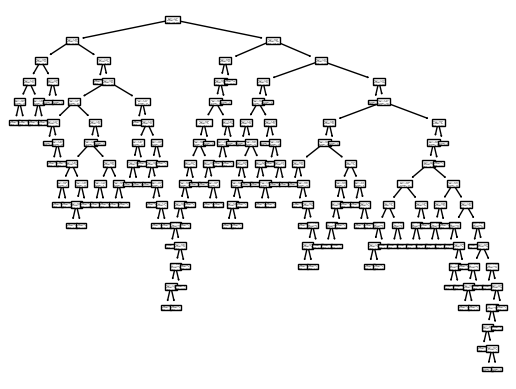

In [212]:
plot_tree(decTree)

In [48]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy = DummyClassifier()
dummy.fit(xtrain, ytrain)


In [49]:
dumPred = dummy.predict(xtest)


In [50]:
print(classification_report(ytest, dumPred))

              precision    recall  f1-score   support

           0       0.54      1.00      0.71       201
           1       0.00      0.00      0.00       168

    accuracy                           0.54       369
   macro avg       0.27      0.50      0.35       369
weighted avg       0.30      0.54      0.38       369



c:\Users\Shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shawn\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [52]:
knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)

KNeighborsClassifier()

In [53]:
kpred = knn.predict(xtest)

In [56]:
xtrain

,surface_pressure,surface_solar_radiation,relative_humidity
632,-0.947542,0.500605,-0.172533
102,0.545116,0.998625,-0.131177
402,-0.535758,0.394615,-0.510199
702,-0.888882,0.661269,-0.462717
448,-0.360294,0.374302,0.790122
...,...,...,...
389,-0.041229,-0.234195,0.242618
681,-0.053361,1.302435,-1.996547
477,0.433250,-0.809697,0.311056
558,1.597787,-0.097414,-0.131078


In [54]:
print(classification_report(ytest, kpred))

              precision    recall  f1-score   support

           0       0.61      0.75      0.67       201
           1       0.58      0.42      0.49       168

    accuracy                           0.60       369
   macro avg       0.59      0.58      0.58       369
weighted avg       0.60      0.60      0.59       369



In [57]:
from sklearn.linear_model import RidgeClassifier

In [59]:
ridge = RidgeClassifier()
ridge.fit(xtrain, ytrain)

RidgeClassifier()

In [60]:
ridpred = ridge.predict(xtest)
print(classification_report(ytest, ridpred))

              precision    recall  f1-score   support

           0       0.55      0.95      0.69       201
           1       0.50      0.06      0.11       168

    accuracy                           0.54       369
   macro avg       0.52      0.50      0.40       369
weighted avg       0.53      0.54      0.43       369

